In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=f9d5477263d936ab956e13461bc229babfa8b6c0056be9b8aa3b65d12b881c3c
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import plotly.graph_objects as go
import geopandas as gpd
import networkx as nx
from pyspark.sql import functions as F
import numpy as np

In [ ]:
spark = SparkSession.builder.appName("BrazilTradeAnalysis").getOrCreate()

# Carregando os dados
df_exp = spark.read.csv('/content/drive/MyDrive/comex/EXP_COMPLETA.csv', header=True, sep=';')
df_imp = spark.read.csv('/content/drive/MyDrive/comex/IMP_COMPLETA.csv', header=True, sep=';')


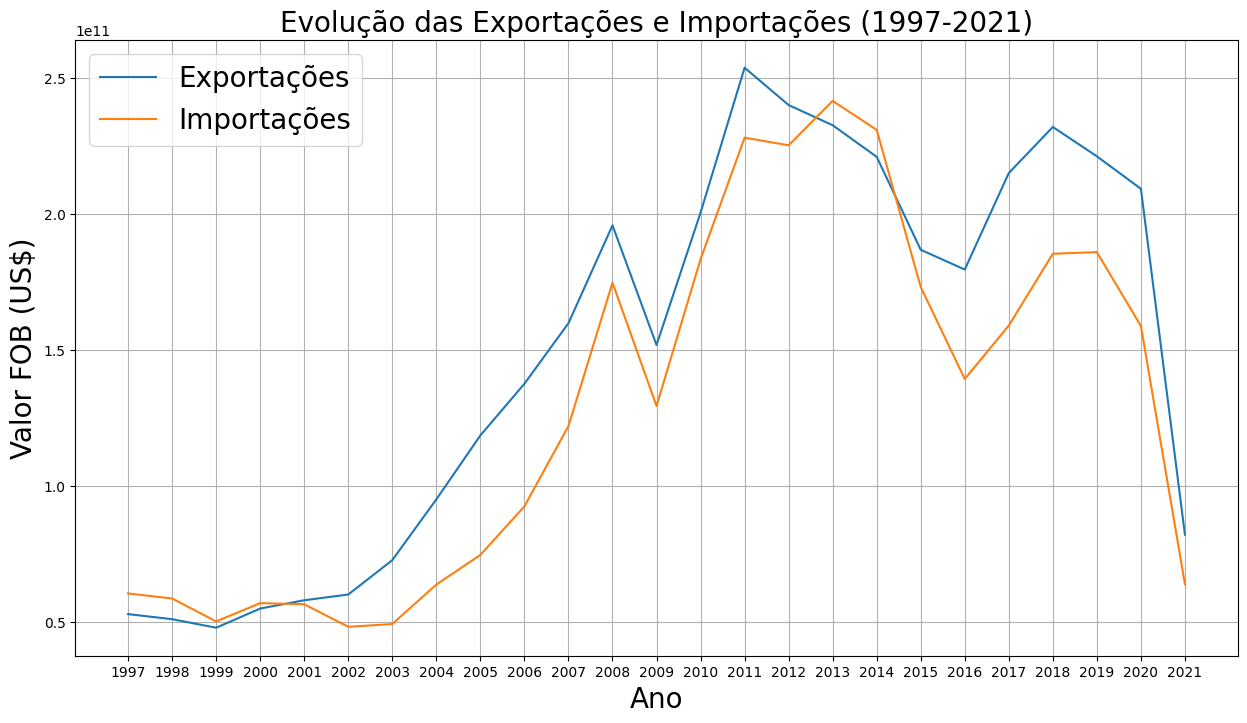

In [ ]:
# Agrupando por ano e somando o valor FOB
grouped_exp = df_exp.groupBy('CO_ANO').agg(sum('VL_FOB').alias('TotalExport'))
grouped_imp = df_imp.groupBy('CO_ANO').agg(sum('VL_FOB').alias('TotalImport'))

# Convertendo para pandas para plotar
pdf_exp = grouped_exp.toPandas().sort_values(by='CO_ANO')
pdf_imp = grouped_imp.toPandas().sort_values(by='CO_ANO')

# Definindo as cores
color_export = "#1f77b4"  # Azul
color_import = "#ff7f0e"  # Laranja

plt.figure(figsize=(15, 8))
plt.plot(pdf_exp['CO_ANO'], pdf_exp['TotalExport'], label='Exportações', color=color_export )
plt.plot(pdf_imp['CO_ANO'], pdf_imp['TotalImport'], label='Importações', color=color_import)
plt.title('Evolução das Exportações e Importações (1997-2021)', fontsize = 20)
plt.xlabel('Ano', fontsize=20)
plt.ylabel('Valor FOB (US$)', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)
plt.show()


In [ ]:
# Carregar o shapefile do Brasil
brazil = gpd.read_file('/content/BR_UF_2022.shp')

# Filtrar os dados para o ano de 2021
df_exp_2021 = df_exp.filter(df_exp.CO_ANO == 2021)
df_imp_2021 = df_imp.filter(df_imp.CO_ANO == 2021)

# Agrupar os dados por estado e somar o valor FOB para 2021
export_by_state_2021 = df_exp_2021.groupBy('SG_UF_NCM').agg(sum('VL_FOB').alias('TotalExport')).toPandas()
import_by_state_2021 = df_imp_2021.groupBy('SG_UF_NCM').agg(sum('VL_FOB').alias('TotalImport')).toPandas()

# Mesclar o dataframe geopandas com os dados de exportação e importação de 2021
brazil_export_2021 = brazil.merge(export_by_state_2021, left_on='SIGLA_UF', right_on='SG_UF_NCM')
brazil_import_2021 = brazil.merge(import_by_state_2021, left_on='SIGLA_UF', right_on='SG_UF_NCM')

# Ordenar os dataframes pelo valor de exportação/importação
brazil_export_2021 = brazil_export_2021.sort_values(by='TotalExport', ascending=False)
brazil_import_2021 = brazil_import_2021.sort_values(by='TotalImport', ascending=False)

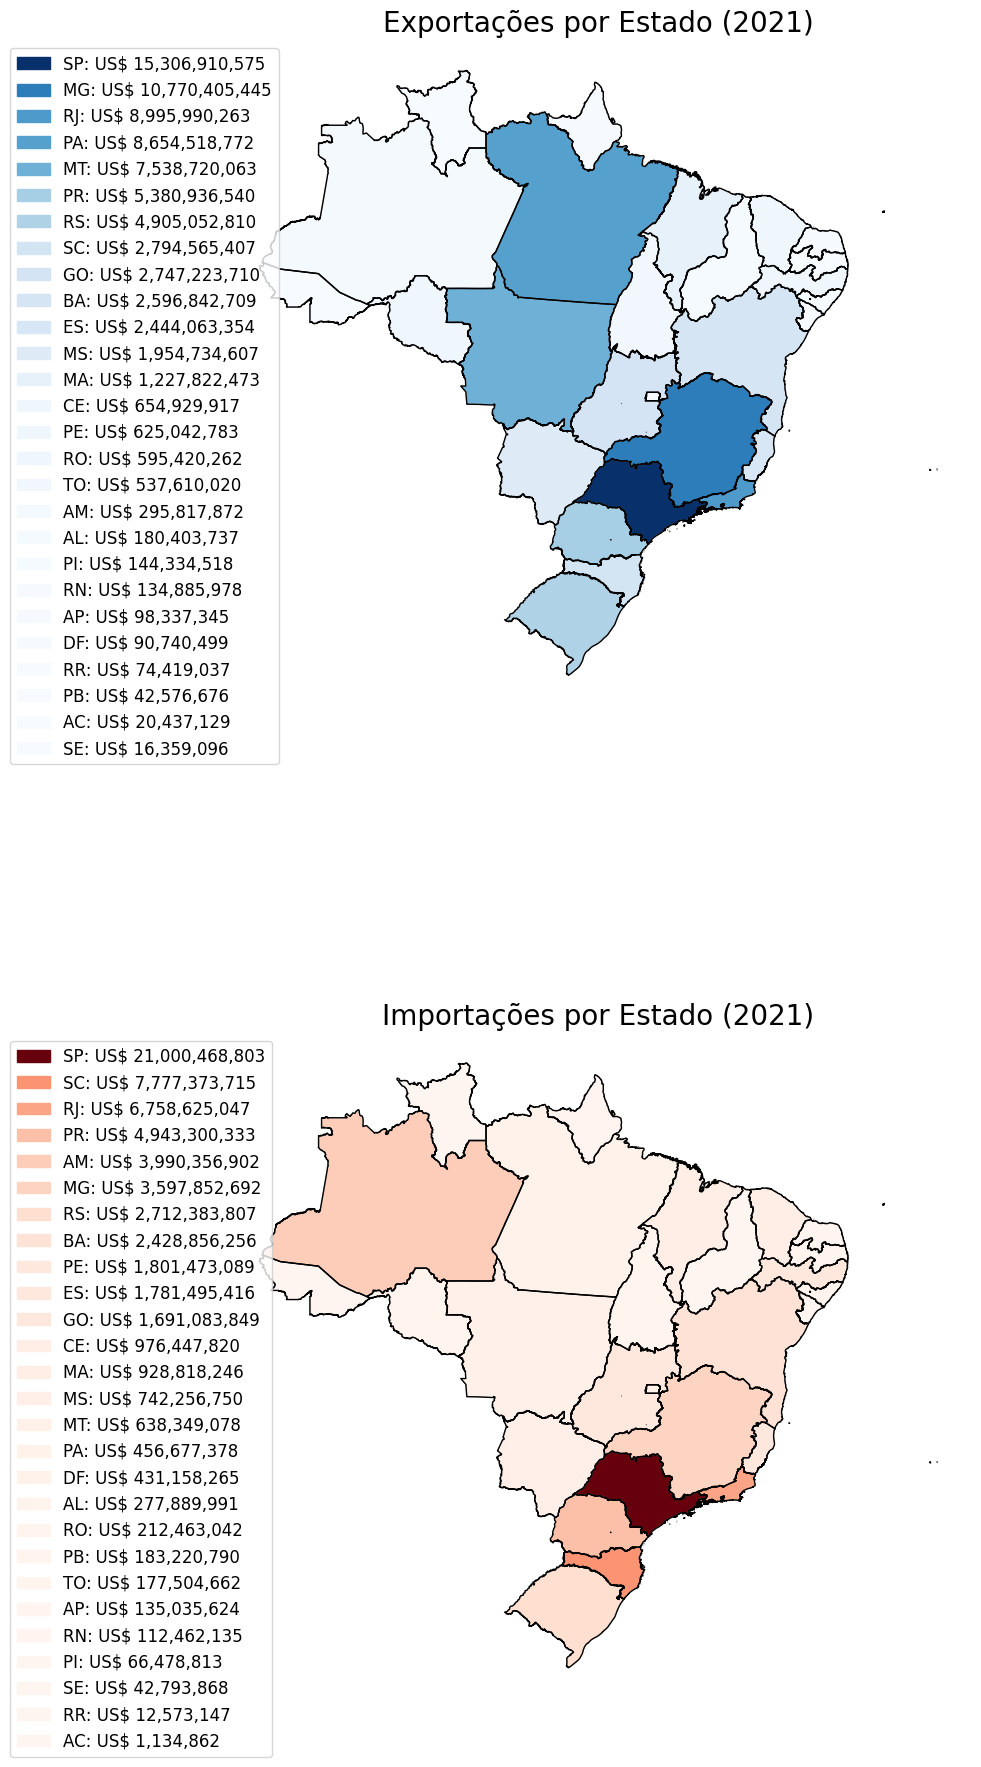

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 20))

# Plotar exportações
brazil_export_2021.boundary.plot(ax=ax[0], linewidth=1, color='black')
brazil_export_2021.plot(column='TotalExport', cmap='Blues', linewidth=0.8, ax=ax[0], edgecolor='0.8')
ax[0].set_title('Exportações por Estado (2021)',fontsize=20)
ax[0].axis('off')

# Plotar importações
brazil_import_2021.boundary.plot(ax=ax[1], linewidth=1, color='black')
brazil_import_2021.plot(column='TotalImport', cmap='Reds', linewidth=0.8, ax=ax[1], edgecolor='0.8')
ax[1].set_title('Importações por Estado (2021)',fontsize=20)
ax[1].axis('off')

# Função para calcular a cor de cada estado
def calculate_color(data, cmap, column):
    norm = plt.Normalize(vmin=data[column].min(), vmax=data[column].max())
    return [cmap(norm(value)) for value in data[column]]

colors_export = calculate_color(brazil_export_2021, plt.cm.Blues, 'TotalExport')
colors_import = calculate_color(brazil_import_2021, plt.cm.Reds, 'TotalImport')

# Criar legendas personalizadas
legend_labels_export = [mpatches.Patch(color=color, label=f"{state}: US$ {value:,.0f}") for state, color, value in zip(brazil_export_2021['SIGLA_UF'], colors_export, brazil_export_2021['TotalExport'])]
legend_labels_import = [mpatches.Patch(color=color, label=f"{state}: US$ {value:,.0f}") for state, color, value in zip(brazil_import_2021['SIGLA_UF'], colors_import, brazil_import_2021['TotalImport'])]

# Ajustando a posição da legenda
ax[0].legend(handles=legend_labels_export, loc='upper left', fontsize='large', bbox_to_anchor=(-0.3, 1))
ax[1].legend(handles=legend_labels_import, loc='upper left', fontsize='large', bbox_to_anchor=(-0.3, 1))

plt.tight_layout()
plt.show()

In [ ]:
# Mapeamento dos códigos NCM para os nomes dos produtos
ncm_mapping = {
    '26011100': 'Minérios de ferro',
    '27090010': 'Óleos brutos de petróleo',
    '12019000': 'Soja, exceto para semeadura',
    '23040090': 'Resíduos sólidos da extração de soja',
    '09011110': 'Café não torrado',
    '12010090': 'Trigo e mistura de trigo com centeio',
    '47032900': 'Pastas químicas de madeira de coníferas',
    '17011400': 'Açúcares de cana em bruto',
    '02071400': 'Frangos e suas partes',
    '02023000': 'Carne de bovina desossada'
}

# Agrupando por ano, produto e somando o valor FOB
grouped_exp_product = df_exp.groupBy(['CO_ANO', 'CO_NCM']).agg(F.sum('VL_FOB').alias('TotalExportValue'))

# Convertendo para pandas e pivotando para formato largo
pdf_exp_product = grouped_exp_product.toPandas().pivot(index='CO_ANO', columns='CO_NCM', values='TotalExportValue').fillna(0)

# Convertendo os anos para inteiros
pdf_exp_product.index = pdf_exp_product.index.astype(int)

# Ordenando os produtos pelo valor total e selecionando os top N
sorted_products = pdf_exp_product.sum().sort_values(ascending=False).index
top_n_products = sorted_products[:10]


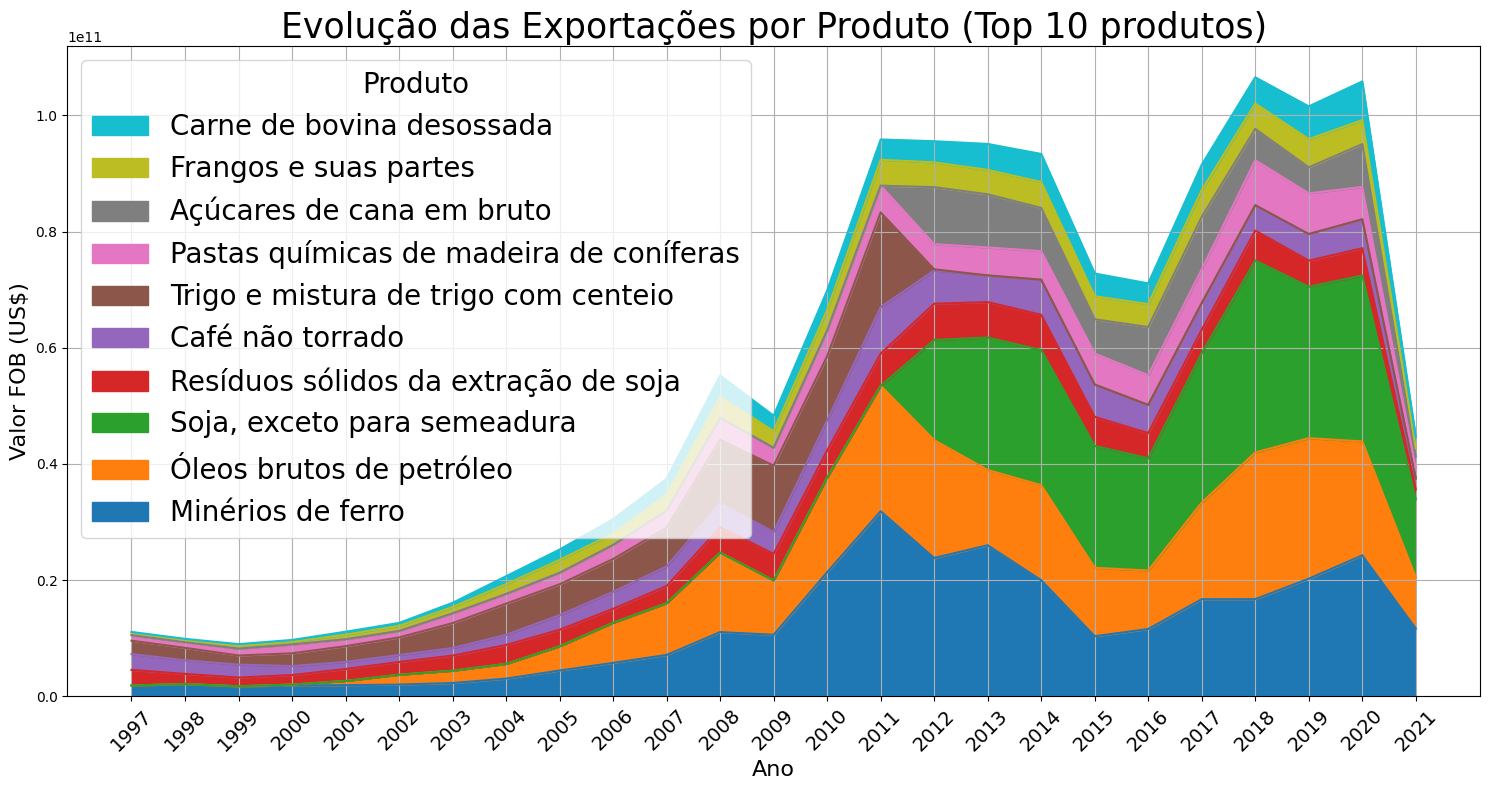

In [ ]:
# Plotando o gráfico de área empilhada para os top N produtos
ax = pdf_exp_product[top_n_products].plot.area(figsize=(15, 8), stacked=True)
plt.title('Evolução das Exportações por Produto (Top 10 produtos)', fontsize=25)  # Aumentando o tamanho do título do gráfico
plt.xlabel('Ano', fontsize=16)  # Aumentando o tamanho do título do eixo x
plt.ylabel('Valor FOB (US$)', fontsize=16)

# Substituindo os códigos NCM pelos nomes dos produtos na legenda
product_names = [ncm_mapping[code] for code in top_n_products]
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(product_names), title='Produto',  title_fontsize='20', loc='upper left', fontsize=20)  # Aumentando o tamanho da legenda

plt.grid(True)

# Ajustando os ticks do eixo x para exibir todos os anos
ax.set_xticks(pdf_exp_product.index)
ax.set_xticklabels(pdf_exp_product.index, rotation=45, fontsize=14)  # Aumentando o tamanho dos ticks do eixo x

plt.tight_layout()
plt.show()

In [ ]:
# Mapeamento dos códigos NCM para os nomes dos produtos
ncm_mapping = {
    '26011100': 'Minérios de ferro',
    '27090010': 'Óleos brutos de petróleo',
    '12019000': 'Soja, exceto para semeadura',
    '23040090': 'Resíduos sólidos da extração de soja',
    '09011110': 'Café não torrado',
    '12010090': 'Trigo e mistura de trigo com centeio',
    '47032900': 'Pastas químicas de madeira de coníferas',
    '17011400': 'Açúcares de cana em bruto',
    '02071400': 'Frangos e suas partes',
    '02023000': 'Carne de bovina desossada'
}

# Carregando o arquivo CSV com os nomes dos países
df_country_names = pd.read_csv('/content/CO_PAIS.csv', delimiter=';', quotechar='"')

# Criando um dicionário para mapear CO_PAIS para NO_PAIS
country_mapping = dict(zip(df_country_names['CO_PAIS'].astype(str), df_country_names['NO_PAIS']))
country_mapping['063'] = "Argentina"
country_mapping['023'] = "Alemanha"

# Filtrando os dados de exportações para 2021
df_exp_2021 = df_exp[df_exp['CO_ANO'] == 2021]

# Agrupando os dados de exportações por CO_PAIS e CO_NCM e somando o VL_FOB
grouped_data_exp = df_exp_2021.groupBy('CO_PAIS', 'CO_NCM').agg(F.sum('VL_FOB').alias('TotalExport'))

# Convertendo para pandas para facilitar a manipulação
pdf_exp = grouped_data_exp.toPandas()

# Primeiro, agrupe por país e some todas as exportações
country_exports = pdf_exp.groupby('CO_PAIS')['TotalExport'].sum()

# Em seguida, obtenha os 5 principais países
top_countries_exp = country_exports.nlargest(5).index

# Agora, filtre os principais produtos para esses países
top_products_exports = pdf_exp[pdf_exp['CO_PAIS'].isin(top_countries_exp)].groupby('CO_NCM')['TotalExport'].sum()
top_products_exp = top_products_exports.nlargest(5).index

# Finalmente, filtre o DataFrame original com base nos principais países e produtos
pdf_filtered_exp = pdf_exp[pdf_exp['CO_PAIS'].isin(top_countries_exp) & pdf_exp['CO_NCM'].isin(top_products_exp)]

# Aplicando o mapeamento ao DataFrame pdf_filtered_exp
pdf_filtered_exp['Country_Name'] = pdf_filtered_exp['CO_PAIS'].astype(str).map(country_mapping)

# Atualizando a lista de países e a matriz de fluxo para exportações
top_countries_names_exp = [country_mapping[str(code)] for code in top_countries_exp]
top_products_names_exp = [ncm_mapping[code] for code in top_products_exp]
labels_exp = list(top_countries_names_exp) + top_products_names_exp

matrix_exp = []
for country_name in top_countries_names_exp:
    row = []
    for product_code in top_products_exp:
        value = pdf_filtered_exp[(pdf_filtered_exp['Country_Name'] == country_name) & (pdf_filtered_exp['CO_NCM'] == product_code)]['TotalExport'].sum()
        row.append(value)
    matrix_exp.append(row)

# Definindo uma paleta de cores para os países
color_palette_exp = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
color_map_exp = dict(zip(top_countries_names_exp, color_palette_exp))

# Modificando os rótulos para aplicar negrito
bold_labels_exp = ['<b>' + label + '</b>' if label in top_countries_names_exp or label in top_products_names_exp else label for label in labels_exp]


<ipython-input-15-9d5bbc3c9263>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf_filtered_exp['Country_Name'] = pdf_filtered_exp['CO_PAIS'].astype(str).map(country_mapping)


In [ ]:
# Criando o gráfico de acordes para exportações
fig_exp = go.Figure(data=go.Sankey(
    node = dict(
      pad = 50,
      thickness = 20,
      line = dict(color = "black", width = 1.5),
      label = bold_labels_exp,  # Usando os rótulos em negrito
      color = [color_map_exp.get(name, '#CCCCCC') for name in labels_exp]
    ),
    link = dict(
      source = [labels_exp.index(src) for src in top_countries_names_exp for tgt in top_products_names_exp],
      target = [labels_exp.index(tgt) for src in top_countries_names_exp for tgt in top_products_names_exp],
      value = [val for row in matrix_exp for val in row],
      color = [color_map_exp.get(src, '#CCCCCC') for src in top_countries_names_exp for tgt in top_products_names_exp]
    )
))

fig_exp.update_layout(title_text="Fluxo de Exportação do Brasil em 2021 por produto (top 5)", font=dict(size=30))
fig_exp.show()

In [ ]:
# Mapeamento dos códigos NCM para os nomes dos produtos
ncm_mapping = {
    '27101921': 'Óleos leves de petróleo',
    '85414032': 'Células solares, sem montar',
    '27111100': 'Gás natural liquefeito',
    '87042190': 'Outros veículos automóveis',
    '84119100': 'Partes de turbinas a gás'
}

# Carregando o arquivo CSV com os nomes dos países
df_country_names = pd.read_csv('/content/CO_PAIS.csv', delimiter=';', quotechar='"')

# Criando um dicionário para mapear CO_PAIS para NO_PAIS
country_mapping = dict(zip(df_country_names['CO_PAIS'].astype(str), df_country_names['NO_PAIS']))
country_mapping['063'] = "Argentina"
country_mapping['023'] = "Alemanha"

# Filtrando os dados de importações para 2021
df_imp_2021 = df_imp[df_imp['CO_ANO'] == 2021]

# Agrupando os dados de importação por CO_PAIS e CO_NCM e somando o VL_FOB
grouped_data_imp = df_imp_2021.groupBy('CO_PAIS', 'CO_NCM').agg(sum('VL_FOB').alias('TotalImport'))

# Convertendo para pandas para facilitar a manipulação
pdf_imp = grouped_data_imp.toPandas()

# Primeiro, agrupe por país e some todas as importações
country_imports = pdf_imp.groupby('CO_PAIS')['TotalImport'].sum()

# Em seguida, obtenha os 10 principais países
top_countries_imp = country_imports.nlargest(5).index

# Agora, filtre os principais produtos para esses países
top_products_imports = pdf_imp[pdf_imp['CO_PAIS'].isin(top_countries_imp)].groupby('CO_NCM')['TotalImport'].sum()
top_products_imp = top_products_imports.nlargest(5).index

# Finalmente, filtre o DataFrame original com base nos principais países e produtos
pdf_filtered_imp = pdf_imp[pdf_imp['CO_PAIS'].isin(top_countries_imp) & pdf_imp['CO_NCM'].isin(top_products_imp)]

# Aplicando o mapeamento ao DataFrame pdf_filtered_imp
pdf_filtered_imp['Country_Name'] = pdf_filtered_imp['CO_PAIS'].astype(str).map(country_mapping)

# Atualizando a lista de países e a matriz de fluxo para importações
top_countries_names_imp = [country_mapping[str(code)] for code in top_countries_imp]
top_products_names_imp = [ncm_mapping[code] for code in top_products_imp]
labels_imp = list(top_countries_names_imp) + top_products_names_imp

matrix_imp = []
for country_name in top_countries_names_imp:
    row = []
    for product_code in top_products_imp:
        value = pdf_filtered_imp[(pdf_filtered_imp['Country_Name'] == country_name) & (pdf_filtered_imp['CO_NCM'] == product_code)]['TotalImport'].sum()
        row.append(value)
    matrix_imp.append(row)

# Definindo uma paleta de cores para os países
color_palette_imp = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
color_map_imp = dict(zip(top_countries_names_imp, color_palette_imp))

# Modificando os rótulos para aplicar negrito
bold_labels = ['<b>' + label + '</b>' if label in top_countries_names_imp or label in top_products_names_imp else label for label in labels_imp]


<ipython-input-19-36b6b4288caa>:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Criando o gráfico de acordes para importações
fig_imp = go.Figure(data=go.Sankey(
    node = dict(
      pad = 50,
      thickness = 30,
      line = dict(color = "black", width = 1.5),
      label = bold_labels,  # Usando os rótulos em negrito
      color = [color_map_imp[name] if name in color_map_imp else '#CCCCCC' for name in labels_imp]
    ),
    link = dict(
      source = [labels_imp.index(src) for src in top_countries_names_imp for tgt in top_products_names_imp],
      target = [labels_imp.index(tgt) for src in top_countries_names_imp for tgt in top_products_names_imp],
      value = [val for row in matrix_imp for val in row],
      color = [color_map_imp[src] for src in top_countries_names_imp for tgt in top_products_names_imp]
    )
))

fig_imp.update_layout(title_text="Fluxo de Importação do Brasil em 2021 por produto (top 5)", font=dict(size=30))
fig_imp.show()

In [ ]:
# Carregando o arquivo CSV com os nomes dos países
df_country_names = pd.read_csv('/content/CO_PAIS.csv', delimiter=';', quotechar='"')

# Criando um dicionário para mapear CO_PAIS para NO_PAIS
country_mapping = dict(zip(df_country_names['CO_PAIS'].astype(str), df_country_names['NO_PAIS']))

# Filtrando os dados de exportações para 2021
df_exp_2021 = df_exp[df_exp['CO_ANO'] == 2021]

# Agregando os dados de exportação por país com o valor total de VL_FOB
agg_exp = df_exp_2021.groupBy('CO_PAIS').agg(F.sum('VL_FOB').alias('TotalExport')).toPandas()

# Mapeando os códigos dos países para seus nomes
agg_exp['Country_Name'] = agg_exp['CO_PAIS'].map(country_mapping)

# Filtrando para os top 10 países com base no TotalExport
agg_exp = agg_exp.nlargest(5, 'TotalExport')

agg_exp.loc[agg_exp['CO_PAIS'] == "063", 'Country_Name'] = "Argentina"
agg_exp.loc[agg_exp['CO_PAIS'] == "023", 'Country_Name'] = "Alemanha"


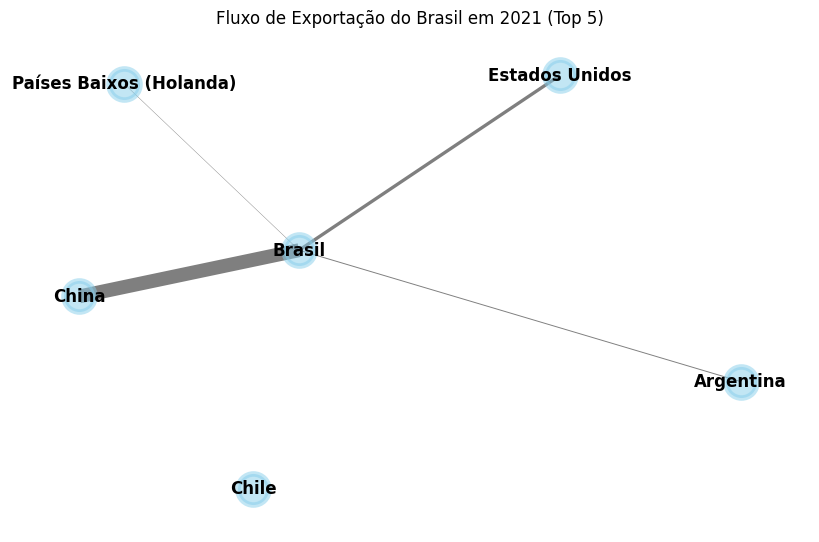

In [ ]:
# Criando um gráfico direcionado
G = nx.DiGraph()

# Adicionando o nó do Brasil
G.add_node('Brasil')

# Adicionando nós (países) e arestas com peso baseado no TotalExport
for index, row in agg_exp.iterrows():
    country = row['Country_Name']
    G.add_node(country)
    G.add_edge('Brasil', country, weight=row['TotalExport'])

# Normalizando os pesos das arestas para o intervalo [0,1]
edges = G.edges(data=True)
max_weight = max([w['weight'] for _, _, w in edges])
min_weight = min([w['weight'] for _, _, w in edges])
edge_widths = [(w['weight'] - min_weight) / (max_weight - min_weight) for _, _, w in edges]

# Ajustando a escala para que faça sentido visualmente
scale_factor = 10
edge_widths = [e * scale_factor for e in edge_widths]

# Definindo o tamanho da figura
plt.figure(figsize=(8, 5))  # Ajuste os valores conforme necessário

# Desenhando o gráfico
pos = nx.spring_layout(G)  # Posição dos nós
nx.draw(G, pos, with_labels=False, node_size=500, node_color="skyblue", node_shape="o", alpha=0.5, linewidths=4, width=edge_widths, arrows=False)  # Adicionado arrows=False
nx.draw_networkx_labels(G, pos, font_weight='bold')  # Adicionando rótulos com negrito
plt.title("Fluxo de Exportação do Brasil em 2021 (Top 5)")
plt.show()

In [ ]:
# Carregando o arquivo CSV com os nomes dos países
df_country_names = pd.read_csv('/content/CO_PAIS.csv', delimiter=';', quotechar='"')

# Criando um dicionário para mapear CO_PAIS para NO_PAIS
country_mapping = dict(zip(df_country_names['CO_PAIS'].astype(str), df_country_names['NO_PAIS']))

# Filtrando os dados de importações para 2021
df_imp_2021 = df_imp[df_imp['CO_ANO'] == 2021]

# Agregando os dados de importação por país com o valor total de VL_FOB
agg_imp = df_imp_2021.groupBy('CO_PAIS').agg(F.sum('VL_FOB').alias('TotalImport')).toPandas()

# Mapeando os códigos dos países para seus nomes
agg_imp['Country_Name'] = agg_imp['CO_PAIS'].map(country_mapping)

# Filtrando para os top 5 países com base no TotalImport
agg_imp = agg_imp.nlargest(5, 'TotalImport')

agg_imp.loc[agg_imp['CO_PAIS'] == "063", 'Country_Name'] = "Argentina"
agg_imp.loc[agg_imp['CO_PAIS'] == "023", 'Country_Name'] = "Alemanha"

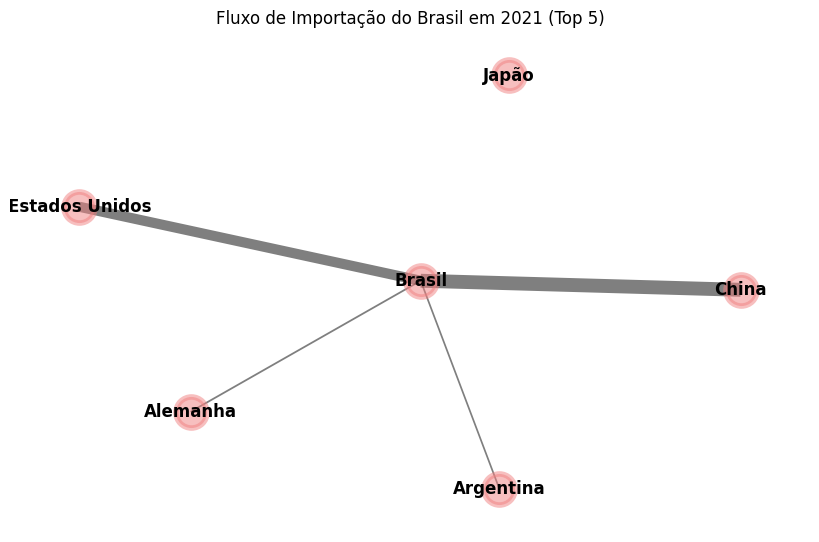

In [ ]:
# Criando um gráfico direcionado
G_imp = nx.DiGraph()

# Adicionando o nó do Brasil
G_imp.add_node('Brasil')

# Adicionando nós (países) e arestas com peso baseado no TotalImport
for index, row in agg_imp.iterrows():
    country = row['Country_Name']
    G_imp.add_node(country)
    G_imp.add_edge('Brasil', country, weight=row['TotalImport'])

# Normalizando os pesos das arestas para o intervalo [0,1]
edges_imp = G_imp.edges(data=True)
max_weight_imp = max([w['weight'] for _, _, w in edges_imp])
min_weight_imp = min([w['weight'] for _, _, w in edges_imp])
edge_widths_imp = [(w['weight'] - min_weight_imp) / (max_weight_imp - min_weight_imp) for _, _, w in edges_imp]

# Ajustando a escala para que faça sentido visualmente
scale_factor = 10
edge_widths_imp = [e * scale_factor for e in edge_widths_imp]

# Definindo o tamanho da figura
plt.figure(figsize=(8, 5))  # Ajuste os valores conforme necessário

# Desenhando o gráfico
pos_imp = nx.spring_layout(G_imp)  # Posição dos nós
nx.draw(G_imp, pos_imp, with_labels=False, node_size=500, node_color="lightcoral", node_shape="o", alpha=0.5, linewidths=4, width=edge_widths_imp, arrows=False)  # Adicionado arrows=False
nx.draw_networkx_labels(G_imp, pos_imp, font_weight='bold')  # Adicionando rótulos com negrito
plt.title("Fluxo de Importação do Brasil em 2021 (Top 5)")
plt.show()